In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sympy

from analysis import loop_analysis, rlocus, bode

plt.rcParams['figure.figsize'] = (10, 10)

# Pitch-Rate CAS Design-Dhruv Jain


In [2]:
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=550), p=p, phi_dot=0, theta_dot=0, psi_dot=0.349066, gam=0)

In [3]:
def f_control(t, x):
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg + 1*np.sin(2*np.pi*2*t),
        rdr_cmd_deg=u0.rdr_cmd_deg)

f_control(0, x0)

Control(thtl=DM(0.939641), ail_cmd_deg=DM(0.0832868), elv_cmd_deg=DM(-1.41359), rdr_cmd_deg=DM(-0.3512))

# A,B,C,D matrices

In [4]:
ss = f16.StateSpace
ss = f16.linearize(x0, u0, p)
print("A= ",ss.A)
print("B= ",ss.B)
print("C= ",ss.C)
print("D= ",ss.D)

A=  [[-1.00633464e-01 -2.20855448e+02  3.16848365e+01 -7.89498027e+00
  -3.11844580e+01  0.00000000e+00  4.29768610e-04 -8.59442671e+00
   1.81924240e-03  0.00000000e+00  0.00000000e+00  1.74909305e-04
   3.28097058e-01  7.20147501e-05 -1.61955145e-01  1.96611699e-04]
 [-5.51083668e-04 -1.15177247e+00  2.53266367e-04 -5.58711321e-02
   1.41691386e-02  0.00000000e+00 -3.92282765e-04  9.03393840e-01
  -1.00812602e-04  0.00000000e+00  0.00000000e+00  1.02191877e-05
  -1.53304645e-04  0.00000000e+00 -2.34025336e-03  0.00000000e+00]
 [-1.05585059e-04  1.24239855e-04 -3.52805546e-01  9.36199183e-03
  -2.37565513e-03  0.00000000e+00  2.50831071e-01  6.32908530e-06
  -9.60362120e-01  0.00000000e+00  0.00000000e+00 -1.89285193e-10
  -2.41616379e-07  3.23274943e-04  1.19266585e-07  8.82591907e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.49367622e-01  0.00000000e+00  1.00000000e+00  4.10438538e-02
   6.65689383e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

Text(0.5, 1.0, 'angle of attack')

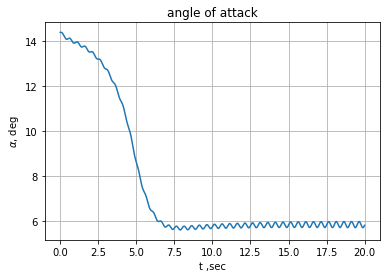

In [5]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)
plt.plot(res['t'], np.rad2deg(res['x'][:, f16.State().name_to_index('alpha')]))
plt.xlabel('t ,sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()
plt.title('angle of attack')

Text(0.5, 1.0, 'trajectory')

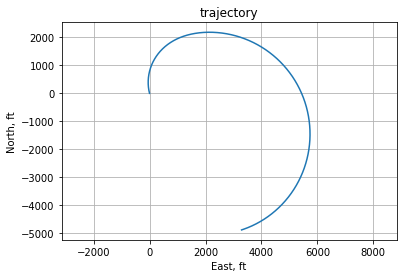

In [6]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)

plt.plot(res['x'][:, f16.State().name_to_index('p_E')], res['x'][:, f16.State().name_to_index('p_N')])
plt.axis('equal');
plt.xlabel('East, ft')
plt.ylabel('North, ft')
plt.grid()
plt.title('trajectory')

In [7]:
def f_control(t, x):
    print(x)
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg + 1*np.sin(2*np.pi*2*t),
        rdr_cmd_deg=u0.rdr_cmd_deg)

In [8]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)

In [9]:
ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
sys3 = control.feedback(G, 0.2*10/(s+10)*select(2, 0))


# Transfer Function

In [10]:
PI_c = 2.2 + 1*0.8/s
G0 = PI_c*sys3[1,0]
Gc = G0/(1+G0)
print('The Transfer Function is: ',Gc.minreal())

The Transfer Function is:  
         599.9 s^3 + 6932 s^2 + 9589 s + 2599
------------------------------------------------------
s^5 + 32.83 s^4 + 879.6 s^3 + 7412 s^2 + 9707 s + 2599



1.1943706837313768
0.14014014014014015
The PI control satisfy the given constraint


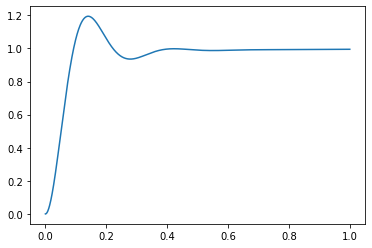

In [18]:
t,y = control.step_response(Gc,T=np.linspace(0,1,1000))
#plt.figure(figsize=(l))

plt.plot(t,y)
print(max(y))
for i in range(len(t)):
    if y[i]==max(y):
        print(t[i])
print('The PI control satisfy the given constraint')

# 10 Deg

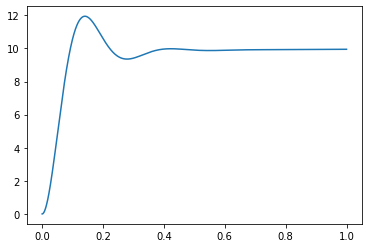

In [19]:
t,y = control.step_response(Gc,T=np.linspace(0,1,1000))
plt.plot(t,10*y)

# 100 Deg

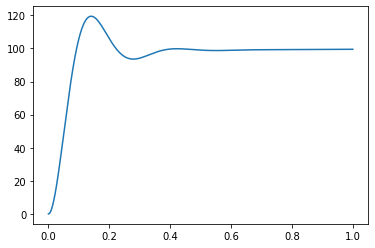

In [20]:
t,y = control.step_response(Gc,T=np.linspace(0,1,1000))
plt.plot(t,100*y)

3 states have been removed from the model


[-21, 0, -8, 8]

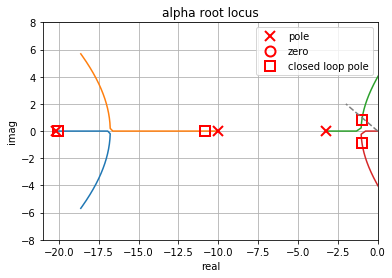

In [24]:
from analysis import rlocus
H = (10/(s+10))*select(2, 0)
plt.figure()
kalpha = 0.3
rlocus('alpha', control.minreal(H*G), kvect=np.linspace(0, 10, 1000), k=kalpha);
plt.plot([0, -2], [0, 2], '--')
plt.axis([-21, 0, -8, 8])

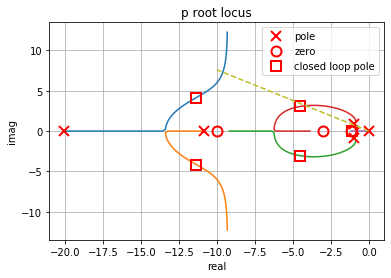

In [25]:
plt.figure()
sys3 = control.feedback(G, kalpha*(10/(s+10))*select(2, 0))
rlocus('p', (s+3)/s*sys3[1, 0], kvect=np.linspace(0, 1, 1000), k=0.5)
plt.plot([0, -10], [0, 10*np.cos(0.707)], '--')
#plt.axis([-20, 0, -5, 5])
